<a href="https://colab.research.google.com/github/Shubh-Goyal-07/cloudPhysician_inter_iit/blob/main/ColudPhy_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Primary Pipeline***


---





In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Importing required libraries and modules and installing required dependencies.*

In [72]:
# Importing required libraries and functions

import torch, torchvision                                                                                                         
import torchvision.transforms as T    

import matplotlib.pyplot as plt     

import pycocotools.coco as coco                                                                                                   
from pycocotools.coco import COCO   

import numpy as np

from PIL import Image
import skimage.io as io                                                                                                           

import pylab

from pathlib import PurePath
from typing import Optional, Callable, Sequence, Tuple

In [73]:
# installing parseq dependency

!pip install pytorch_lightning
!pip install timm

import pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Defining some required values and variables to be used later.*

In [74]:
torch.set_grad_enabled(False)

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],                                                    
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]] 

*Loading the models to be used.*

In [75]:
global model_1, model_2, parseq

# Function to load model for monitor detection
def load_1():
    model = torch.hub.load('facebookresearch/detr',                                                                                   
                        'detr_resnet50',                                                                                           
                        pretrained=False,
                        num_classes=1)

    checkpoint = torch.load('/content/drive/MyDrive/interiit/checkpoint.pth',
                            map_location='cpu')

    model.load_state_dict(checkpoint['model'],
                        strict=False)

    model.eval()

    return model

# Function to load model for vitals detection
def load_2():
    model = torch.hub.load('facebookresearch/detr',                                                                                   
                       'detr_resnet50',                                                                                           
                       pretrained=False,
                       num_classes=6)

    checkpoint = torch.load('/content/drive/MyDrive/interiit/checkpoint3.pth',
                            map_location='cpu')

    model.load_state_dict(checkpoint['model'],
                        strict=False)

    model.eval()

    return model

# Function to load parseq for digit recognition
def load_3():
    parseq = torch.hub.load('baudm/parseq', 'parseq', pretrained=True).eval()

    return parseq

# Loading the models
model_1 = load_1()
model_2 = load_2()
parseq = load_3()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
Using cache found in /root/.cache/torch/hub/baudm_parseq_main


*Supporting functions for model_1 and model_2.*

In [76]:
# Functions required for visualization of processed images and detected objects

# Functions for bounding box scaling
def box_cxcywh_to_xyxy(x):                                                                                                        
    x_c, y_c, w, h = x.unbind(1)                                                                                                  
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),                                                                                        
         (x_c + 0.5 * w), (y_c + 0.5 * h)]                                                                                        
    return torch.stack(b, dim=1)                                                                                                  
                                                                                                                                  
def rescale_bboxes(out_bbox, size):                                                                                               
    img_w, img_h = size                                                                                                           
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Function to get bbox with confidence above 0.7
def filter_bboxes_from_outputs(im, outputs, threshold=0.7):

    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled

# Function to plot the results i.e. highlight detected objects in given images
def plot_finetuned_results(pil_img, finetuned_classes, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [77]:
# Function to give object class along with its bbox coordinates.
def detect_dict(finetuned_classes, prob=None, boxes=None):
    if prob is not None and boxes is not None:
        output = {}
        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
            cl = p.argmax()
            output[finetuned_classes[cl]] = [xmin, ymin, xmax, ymax]

    return output

In [78]:
# Function to process image and get results from the models
def run_worflow(my_image, my_model, finetuned_classes):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.7, 0.6]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(my_image,
                                                                   outputs,
                                                                   threshold=threshold)

        plot_finetuned_results(my_image, finetuned_classes, probas_to_keep, bboxes_scaled)

        output = detect_dict(finetuned_classes, probas_to_keep, bboxes_scaled)

    return (bboxes_scaled, output)

In [79]:
# Function to get cropped image of the detected object through bbox coordinates from main image
def crop(img, bbox):
    left = bbox[0]
    top = bbox[1]
    right = bbox[2]
    bottom = bbox[3]

    img = img.crop((left, top, right, bottom))

    return img

*ParSeq pipeline along with supporting functions for ParSeq.*

In [80]:
# Function to get cropped images of detected classes of vitals
def cropped_val(monitor, values):
    cropped = {}
    for i in values.keys():
        cropped[i] = crop(monitor, values[i])

    return cropped

# Function to transform image according to ParSeq input.
def get_transform(img_size: Tuple[int], augment: bool = False, rotation: int = 0):
        transforms = []
        if augment:
            from .augment import rand_augment_transform
            transforms.append(rand_augment_transform())
        if rotation:
            transforms.append(lambda img: img.rotate(rotation, expand=True))
        transforms.extend([
            T.Resize(img_size, T.InterpolationMode.BICUBIC),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])
        return T.Compose(transforms)

# Function to get numerical value
def parseq_digi(img):
    img_transform = get_transform(parseq.hparams.img_size)

    img = img_transform(img).unsqueeze(0)

    logits = parseq(img)
    logits.shape  # torch.Size([1, 26, 95]), 94 characters + [EOS] symbol

    # Greedy decoding
    pred = logits.softmax(-1)
    label, confidence = parseq.tokenizer.decode(pred)

    value = label[0]

    return value


def digi_recog(cropped_val_dic):
    val_dic={}
    for i in cropped_val_dic.keys():
        val_dic[i] = parseq_digi(cropped_val_dic[i])

    return val_dic

*Pipe for model_1 and model_2.*

In [81]:
# Function to get monitor from model_1
def extract_monitor(im):
    finetuned_classes = [
      'monitor',
    ]

    bbox = run_worflow(im, model_1, finetuned_classes)[0]

    monitor = crop(im, bbox.tolist()[0])

    return monitor

# Function to get vital coordinates from model_2
def value_predict(im):
    finetuned_classes_val = [
      'HR','SBP','DBP','MAP','SPO2','RR'
    ]

    output = run_worflow(im, model_2, finetuned_classes_val)[1]

    return output

# ***Main Function***

In [82]:
def inference(image_path:str):
    '''
    Function responsible for inference.
    Args: 
    image_path: str, path to image file. eg. "input/aveksha_micu_mon--209_2023_1_17_12_0_34.jpeg"
    Returns:
    result: dict, final output dictionary. eg. {"HR":"80", "SPO2":"98", "RR":"15", "SBP":"126", "DBP":"86"}
    '''
    result = {}

    im = Image.open(image_path)

    monitor = extract_monitor(im)
    #plt.imshow(monitor)
    values = value_predict(monitor)

    # getting images of classified values
    cropped_val_dic = cropped_val(monitor, values)

    val_dic = digi_recog(cropped_val_dic)

    result = val_dic
    return result

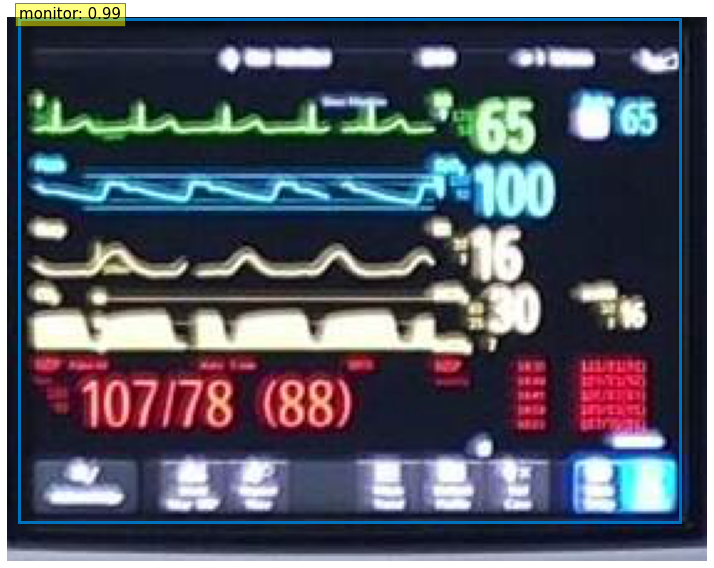

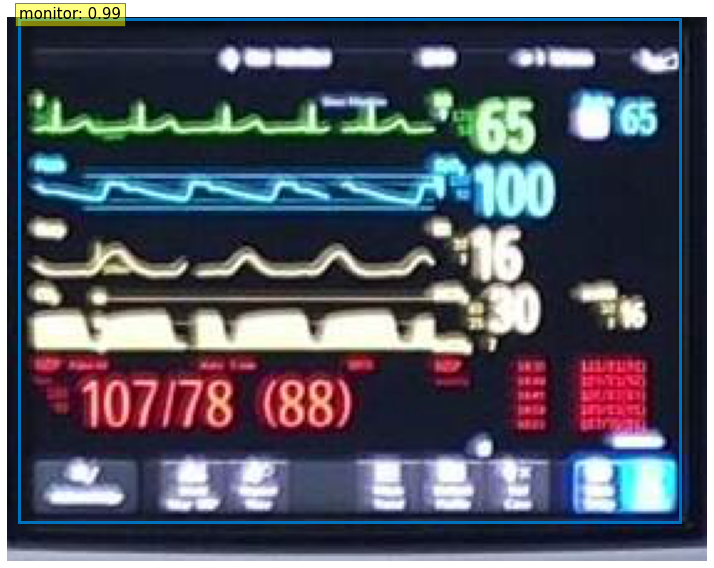

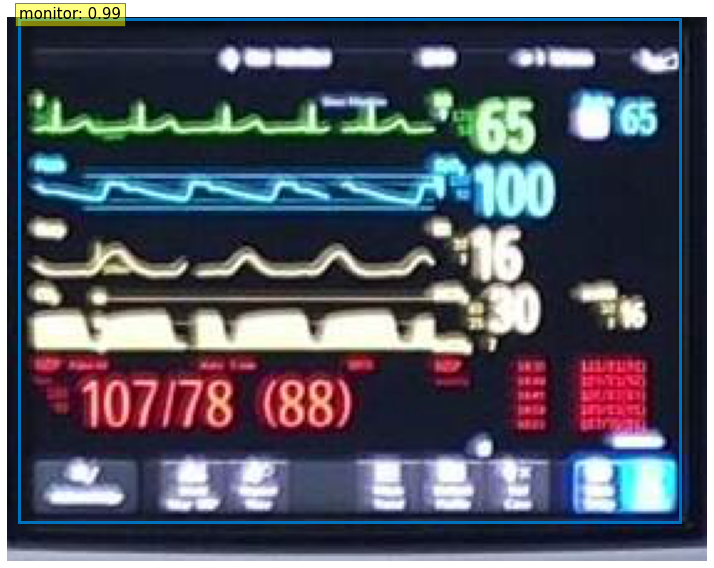

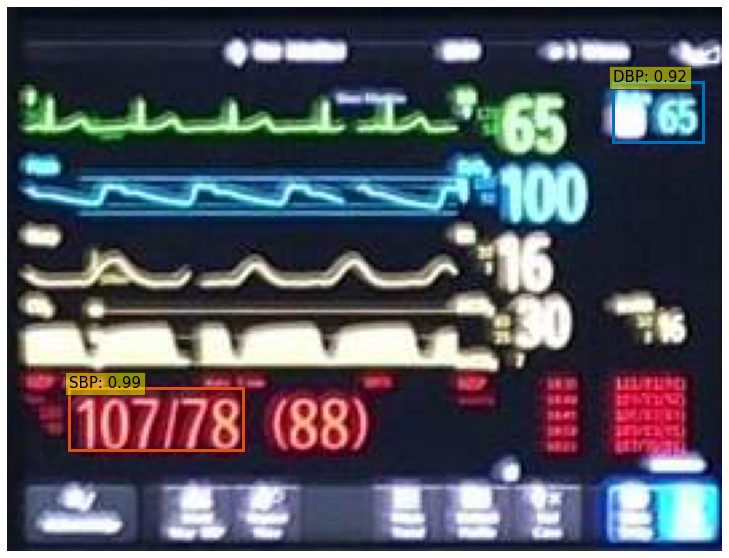

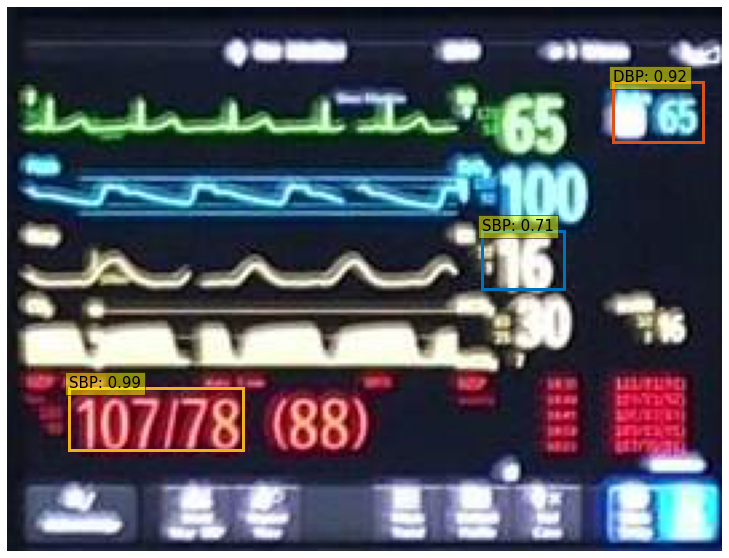

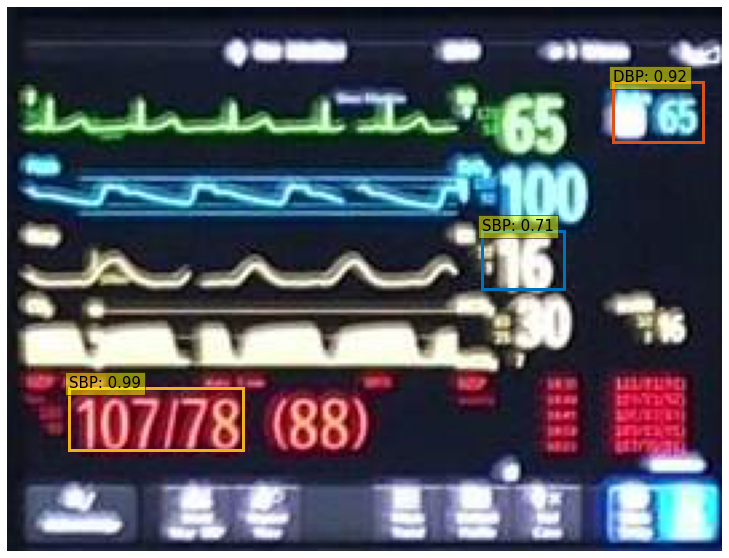

In [94]:
result = inference('/content/3.jpeg')

In [95]:
result

{'SBP': '107/78', 'DBP': '65'}